In [13]:
%run functions.ipynb

np.set_printoptions(precision=3)
np.random.seed(42)

%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


/pio/scratch/1/i272955/anaconda3/envs/master/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['axes', 'figure', 'flatten']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
labels = load_file('data/labels_for_microarray_data.csv')
dataset = load_file('data/microarray_data.csv')[:, 1:].T
print(labels.shape, dataset.shape)
X_train, X_test, y_train, y_test = load_train_and_test_parts()
print("Train and test sizes: {} {}".format(X_train.shape, X_test.shape))
print("(1, 0) labels count in train test: {} {}".format((np.count_nonzero(y_train==1), np.count_nonzero(y_train==0)), 
                                                        (np.count_nonzero(y_test==1), np.count_nonzero(y_test==0))))
standarizer = StandardScaler().fit(X_train)
X_std_train = standarizer.transform(X_train)
X_std_test = standarizer.transform(X_test)

(969,) (969, 12179)
Train and test sizes: (726, 12179) (243, 12179)
(1, 0) labels count in train test: (289, 437) (104, 139)


# How different normalizations influence weights of logistic regression 
(ESC + M/Y to chnage type to markdown code)

### No normalization

In [3]:
clf_logit_no_norm = fit_clf_print_scores(LogisticRegression(solver="liblinear", penalty="l1", C=0.3), X_train, y_train, X_test, y_test)

,ROC AUC,Precision,Recall,F1
train,0.993,0.971,0.941,0.956
test,0.818,0.740,0.712,0.725


### Standarization

In [4]:
clf_logit_std = fit_clf_print_scores(LogisticRegression(solver="liblinear", penalty="l1", C=0.3), X_std_train, y_train, X_std_test, y_test)

,ROC AUC,Precision,Recall,F1
train,1.000,1.000,1.000,1.000
test,0.816,0.685,0.712,0.698


### Quantile normalization from sklearn

In [5]:
normal_transformer = QuantileTransformer(n_quantiles=dataset.shape[0], output_distribution='normal')
uniform_transformer = QuantileTransformer(n_quantiles=dataset.shape[0], output_distribution='uniform')


normalized_train = normal_transformer.fit_transform(X_train)
normalized_test = normal_transformer.transform(X_test)

uniform_train = uniform_transformer.fit_transform(X_train)
uniform_test = uniform_transformer.transform(X_test)

In [6]:
clf_logit_norm = fit_clf_print_scores(LogisticRegression(solver="liblinear", penalty="l1", C=0.3), normalized_train, y_train, normalized_test, y_test)

,ROC AUC,Precision,Recall,F1
train,1.000,1.000,1.000,1.000
test,0.818,0.717,0.683,0.700


In [7]:
clf_logit_unif = fit_clf_print_scores(LogisticRegression(solver="liblinear", penalty="l1", C=0.3), uniform_train, y_train, uniform_test, y_test)

,ROC AUC,Precision,Recall,F1
train,0.978,0.941,0.886,0.913
test,0.792,0.680,0.635,0.657


### Truncating most extreme values to 1% and 99% quantiles

In [8]:
p = X_train.shape[1]

quantiles = np.zeros((2, p))

for i in np.arange(p):
    quantiles[:, i] = np.quantile(X_train[:, i], [0.01, 0.99])
    
X_train_trunc = np.array(X_train)
X_test_trunc = np.array(X_test)

    
for i in np.arange(p):
    X_train_trunc[:, i][X_train_trunc[:, i] > quantiles[1, i]] = quantiles[1,i]
    X_train_trunc[:, i][X_train_trunc[:, i] < quantiles[0, i]] = quantiles[0,i]
    
    X_test_trunc[:, i][X_test_trunc[:, i] > quantiles[1, i]] = quantiles[1,i]
    X_test_trunc[:, i][X_test_trunc[:, i] < quantiles[0, i]] = quantiles[0,i]
    
    
clf_logit_trunc = fit_clf_print_scores(LogisticRegression(solver="liblinear", penalty="l1", C=0.3), X_train_trunc, y_train, X_test_trunc, y_test)

,ROC AUC,Precision,Recall,F1
train,0.993,0.968,0.938,0.953
test,0.812,0.733,0.712,0.722


### Subracting median and dividing by 75% qunatile - 25% qunatile

In [9]:
quantiles = np.zeros((3, p))

for i in np.arange(p):
    quantiles[:, i] = np.quantile(X_train[:, i], [0.25, 0.5, 0.75])
    
X_train_median = np.array(X_train)
X_test_median = np.array(X_test)
    
for i in np.arange(p):
    X_train_median[:, i] = (X_train_median[:, i] - quantiles[1, i])/(quantiles[2, i] - quantiles[0, i])
    X_test_median[:, i] = (X_test_median[:, i] - quantiles[1, i])/(quantiles[2, i] - quantiles[0, i])
    
clf_logit_median = fit_clf_print_scores(LogisticRegression(solver="liblinear", penalty="l1", C=0.3), X_train_median, y_train, X_test_median, y_test)

,ROC AUC,Precision,Recall,F1
train,1.000,1.000,0.997,0.998
test,0.814,0.706,0.692,0.699


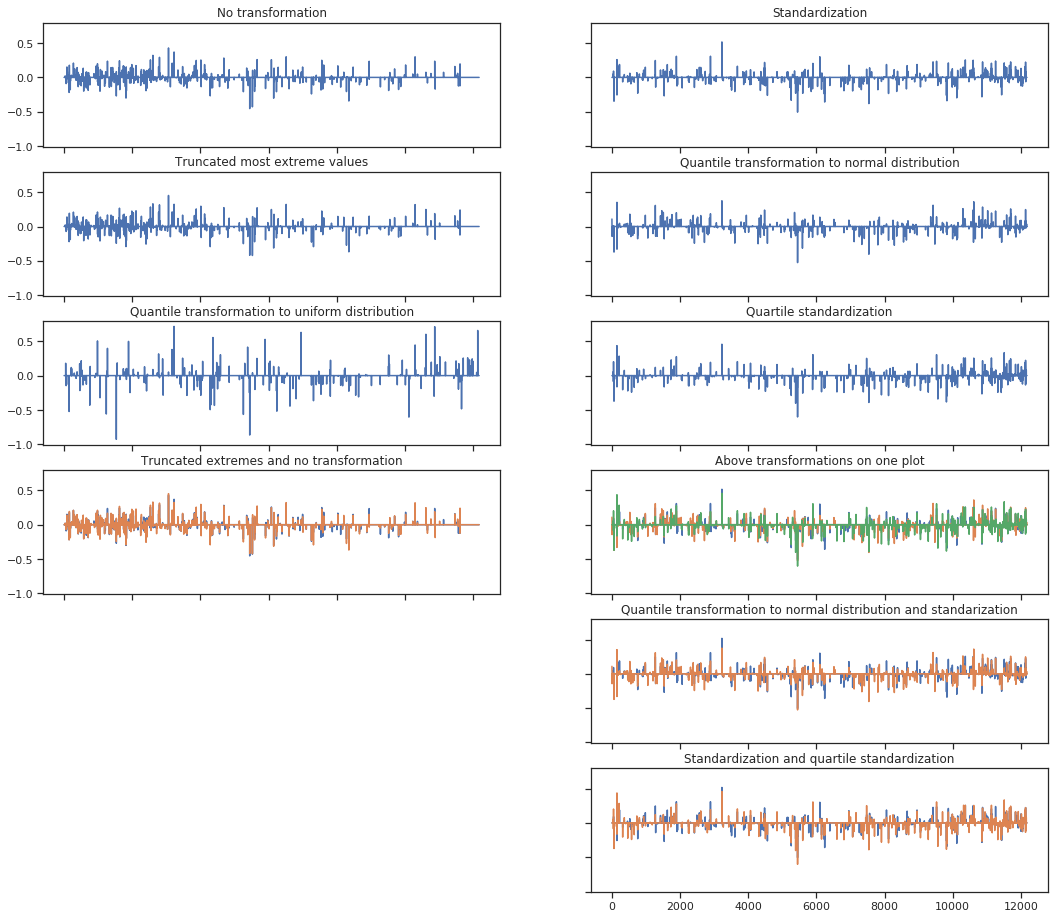

In [18]:
figure, axes = plt.subplots(nrows=6, ncols=2, sharex=True, sharey=True, figsize=(18,16))
(ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12) = axes.flatten()

plot_logit_weights_ax(ax1, clf_logit_no_norm, "No transformation")
plot_logit_weights_ax(ax3, clf_logit_trunc, "Truncated most extreme values")
plot_logit_weights_ax(
    ax5, clf_logit_unif, "Quantile transformation to uniform distribution"
)

plot_logit_weights_ax(ax2, clf_logit_std, "Standardization")
plot_logit_weights_ax(ax4, clf_logit_norm, 'Quantile transformation to normal distribution')
plot_logit_weights_ax(
    ax6, clf_logit_median, "Quartile standardization"
)

plot_logit_weights_ax(ax7, clf_logit_no_norm, "No transformation")
plot_logit_weights_ax(ax7, clf_logit_trunc, "Truncated most extreme values")
ax7.set_title('Truncated extremes and no transformation')

plot_logit_weights_ax(ax8, clf_logit_std, "Standarization")
plot_logit_weights_ax(ax8, clf_logit_norm, 'Quantile transformation to normal distribution')
plot_logit_weights_ax(
    ax8, clf_logit_median, "Quartile standardization"
)

ax8.set_title("Above transformations on one plot")

plot_logit_weights_ax(ax10, clf_logit_std, "Standarization")
plot_logit_weights_ax(ax10, clf_logit_norm, 'Quantile transformation to normal distribution')

ax10.set_title("Quantile transformation to normal distribution and standarization")

plot_logit_weights_ax(ax12, clf_logit_std, "Standarization")
plot_logit_weights_ax(
    ax12, clf_logit_median, "Quartile standardization"
)

ax12.set_title("Standardization and quartile standardization")

ax9.axis('off')
ax11.axis('off')

plt.show()

By looking at the plots above we can conclude:

* uniform quantile normalization is much different from all the others and doesn't work well
* the difference in AUC is not very significant when considered other normalizations
* truncating to marginal quantiles doesn't change weights of logistic regression almost at all
* quantile normal normalization, interquantile normalization and standarization also provide very similar weights in LR

### Conclusion: normalizations don't differ much and the weights are stable => ?
